# 1. Data preparation

In [2]:
import pandas as pd
import numpy as np

In [1]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
!wget $data

--2024-10-07 20:05:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.003s  

2024-10-07 20:05:52 (84.7 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [5]:
df = pd.read_csv('/workspaces/MLZoomCamp/02-regression/homework/laptops.csv') 
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [10]:
df_work = df[['ram', 'storage', 'screen', 'final_price']]
df_work.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


## EDA

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
#all displayed in the notebook
%matplotlib inline 

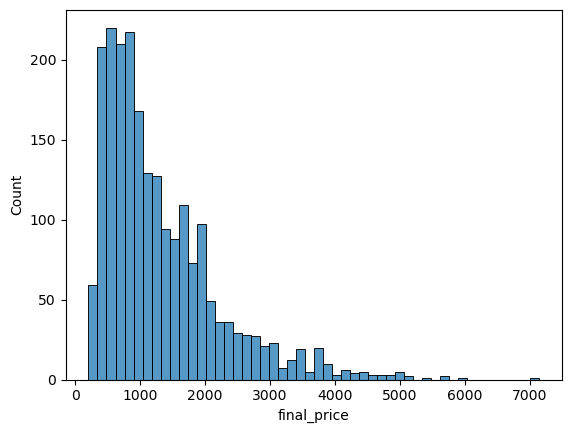

In [23]:
sns.histplot(df.final_price, bins = 50)
plt.show()
# It has a long tail

## Question 1

In [18]:
df_work.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## Question 2

In [20]:
np.median(df_work['ram'])

16.0

## Prepare and split the dataset

In [96]:
n = len(df_work)
n_val = int(len(df_work) * 0.2)
n_test = int(len(df_work) * 0.2)
n_train = len(df_work) - (n_val+ n_test) 

In [ ]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_train = df_work.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df_work.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_work.iloc[idx[n_train+n_val:]].reset_index(drop=True)

In [97]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [98]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Question 3

In [99]:
df_train[list(df_train.columns)].mean()
list(df_train.columns)
train_mean = []
for i in list(df_train.columns):
    train_mean.append(df_train[i].mean())
train_mean

[15.666666666666666, 599.1018518518518, 15.163534416086618]

In [100]:
def prepare_X_fillna_0(df):
    base = df.columns
    df_num = df[base].fillna(0)
    X = df_num.values
    return(X)

def prepare_X_fillna_mean(df):
    base = df.columns
    for v in list(base):
        df[v] = df[v].fillna(df[v].mean())
    X = df.values
    return(X)

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

### With fillna(0)

In [101]:
X_train = prepare_X_fillna_0(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_fillna_0(df_val)
y_pred_val = w0 + X_val.dot(w)

score = round(rmse(y_val, y_pred_val),2)
score
# Gives better score

597.36

In [83]:
X_val.T.dot(X_val)

array([[1.26720000e+05, 4.58886400e+06, 9.84154166e+04],
       [4.58886400e+06, 1.87263552e+08, 3.84249373e+06],
       [9.84154166e+04, 3.84249373e+06, 9.97152328e+04]])

### fillna(With training's mean)

In [102]:
X_train_mean = prepare_X_fillna_mean(df_train)
w0, w = train_linear_regression(X_train_mean, y_train)
for i in range(0, len(train_mean)):
    df_val.iloc[:,i] = df_val.iloc[:,i].fillna(train_mean[i])
X_val = df_val.values
y_pred_val = w0 + X_val.dot(w)
score = round(rmse(y_val, y_pred_val),2)
score

600.27

## Question 4

In [103]:
def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [104]:
for r in [0, 0.001 ,0.01, 0.1, 1, 5, 10, 100, 500, 1000, 10000, 50000]:
    X_train = prepare_X_fillna_0(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r = r)

    X_val = prepare_X_fillna_0(df_val)
    y_pred_val = w0 + X_val.dot(w)

    score = round(rmse(y_val, y_pred_val),2)
    print(r, w0, score)
# Cogemos alpha = r = 100


0 808.9159907332298 600.27
0.001 808.8110453524156 600.26
0.01 807.8677618426024 600.26
0.1 798.554639073666 600.2
1 716.0201412927058 599.67
5 490.72032854123165 598.54
10 352.28821440782576 598.07
100 58.441456919607425 597.61
500 12.909690410664167 597.56
1000 6.827738876222703 597.52
10000 1.2792045899978512 597.48
50000 0.7021126569062257 603.05


## Question 5

In [94]:
idx = np.arange(n)
np.random.seed(0)
np.random.shuffle(idx)
df_train = df_work.iloc[idx[:n_train]].reset_index(drop=True)
df_train

,ram,storage,screen,final_price
0,12,512,15.6,749.00
1,16,512,14.0,899.01
2,32,1000,17.3,2599.00
3,16,512,15.6,999.00
4,16,512,14.0,2109.00
...,...,...,...,...
1291,32,1000,17.3,3099.00
1292,8,256,13.5,951.74
1293,32,1000,15.6,1283.43
1294,32,1000,14.0,2699.00


In [95]:
df_val = df_work.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_work.iloc[idx[n_train+n_val:]].reset_index(drop=True)
X_train = prepare_X_fillna_0(df_train)

array([[  12.  ,  512.  ,   15.6 ,  749.  ],
       [  16.  ,  512.  ,   14.  ,  899.01],
       [  32.  , 1000.  ,   17.3 , 2599.  ],
       ...,
       [  32.  , 1000.  ,   15.6 , 1283.43],
       [  32.  , 1000.  ,   14.  , 2699.  ],
       [  16.  ,  512.  ,   14.  , 1205.  ]])

In [106]:
list_score = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(i)
    np.random.shuffle(idx)
    df_train = df_work.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df_work.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df_work.iloc[idx[n_train+n_val:]].reset_index(drop=True)
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    X_train = prepare_X_fillna_0(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_fillna_0(df_val)
    y_pred_val = w0 + X_val.dot(w)

    score = round(rmse(y_val, y_pred_val),2)
    list_score.append(score)
round(np.std(list_score),3)


29.176

## Question 6

In [111]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
df_train = df_work.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df_work.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_work.iloc[idx[n_train+n_val:]].reset_index(drop=True)
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
df_full_train = pd.concat([df_train,df_val])
X_full_train = prepare_X_fillna_0(df_full_train)
y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression(X_full_train, y_full_train)

X_test = prepare_X_fillna_0(df_test)
y_pred_test = w0 + X_test.dot(w)

score = round(rmse(y_test, y_pred_test),3)
score

608.61